# OsmGt example

## Imports and prepare input parameters

In [1]:
from bokeh.plotting import output_notebook
from bokeh.plotting import show

import geopandas as gpd

from shapely.geometry import Point
from shapely.ops import linemerge

from easy_map_bokeh import EasyMapBokeh

from osmgt import OsmGt

from graph_tool.topology import shortest_path


output_notebook()


location = "Roanne"


Loading BokehJS ...

## Get POIs

In [2]:
%%time

pois_gdf = OsmGt.pois_from_location(location).get_gdf()

2020-09-05 19:39:06 - OsmGtPoi        - INFO     : From location: Roanne
2020-09-05 19:39:06 - OsmGtPoi        - INFO     : Loading data...
2020-09-05 19:39:07 - OsmGtPoi        - INFO     : NominatimApi: Query 200:OK in 0.22 sec.
2020-09-05 19:39:07 - OsmGtPoi        - INFO     : OverpassApi: Query 200:OK in 0.66 sec.
2020-09-05 19:39:07 - OsmGtPoi        - INFO     : Formating data
2020-09-05 19:39:07 - OsmGtPoi        - INFO     : Prepare GeoDataframe
2020-09-05 19:39:07 - OsmGtPoi        - INFO     : GeoDataframe Ready
CPU times: user 109 ms, sys: 15.5 ms, total: 124 ms
Wall time: 984 ms


## Get Roads

In [3]:
%%time
roads_initialized = OsmGt.roads_from_location(
    location,
    mode="vehicle",
    additional_nodes=pois_gdf
)
roads_gdf = roads_initialized.get_gdf()

2020-09-05 19:39:07 - OsmGtRoads      - INFO     : From location: Roanne
2020-09-05 19:39:07 - OsmGtRoads      - INFO     : Loading data...
2020-09-05 19:39:08 - OsmGtRoads      - INFO     : NominatimApi: Query 200:OK in 0.13 sec.
2020-09-05 19:39:09 - OsmGtRoads      - INFO     : OverpassApi: Query 200:OK in 0.82 sec.
2020-09-05 19:39:09 - OsmGtRoads      - INFO     : Rebuild network data
2020-09-05 19:39:09 - OsmGtRoads      - INFO     : Network cleaning...
2020-09-05 19:39:09 - OsmGtRoads      - INFO     : Starting: Adding new nodes on the network
2020-09-05 19:39:09 - OsmGtRoads      - INFO     : Find nearest line for each node
2020-09-05 19:39:09 - OsmGtRoads      - INFO     : Split line
2020-09-05 19:39:09 - OsmGtRoads      - INFO     : Topology lines checker: to add: 184, to split: 182
2020-09-05 19:39:09 - OsmGtRoads      - INFO     : Starting: Find intersections
2020-09-05 19:39:09 - OsmGtRoads      - INFO     : Done: Find intersections
2020-09-05 19:39:09 - OsmGtRoads      - 

## Display roads and nodes

In [4]:
%%time
layers_to_add = [
    {
        "input_gdf": roads_gdf,
        "legend": "roads",
        "color": "black",
    },
    {
        "input_gdf": pois_gdf,
        "legend": "POIs",
        "style": "square",
        "color": "blue",
        "size": 9
    },
]

my_map = EasyMapBokeh(
    "My roads and POIs",
    layers=layers_to_add
)
show(my_map.figure)

CPU times: user 2.21 s, sys: 41.1 ms, total: 2.25 s
Wall time: 2.25 s


## Check topology details

In [5]:
%%time

roads_topology_gdfs = roads_initialized.topology_checker()

lines_unchanged = roads_topology_gdfs["lines_unchanged"]
lines_added = roads_topology_gdfs["lines_added"]
lines_split = roads_topology_gdfs["lines_split"]
nodes_added = roads_topology_gdfs["nodes_added"]
intersections_added = roads_topology_gdfs["intersections_added"]

layers_to_add = [
    {
        "input_gdf": lines_unchanged,
        "legend": "roads unchanged",
        "color": "black",
    },
    {
        "input_gdf": lines_added,
        "legend": "roads added",
        "color": "green",
    },
    {
        "input_gdf": lines_split,
        "legend": "roads split",
        "color": "orange",
    },
    {
        "input_gdf": intersections_added,
        "legend": "Intersections added",
        "color": "brown",
    },
    {
        "input_gdf": nodes_added,
        "legend": "Nodes added",  # POIs here
        "style": "square",
        "color": "blue",
        "size": 9
    },
]

my_map = EasyMapBokeh(
    "Topology about my roads and POIs",
    layers=layers_to_add
)
show(my_map.figure)

2020-09-05 19:39:12 - OsmGtRoads      - INFO     : Prepare topology data
2020-09-05 19:39:12 - OsmGtRoads      - INFO     : GeoDataframe Ready


CPU times: user 3.36 s, sys: 27.3 ms, total: 3.39 s
Wall time: 3.4 s


## Get the graph-tool network and display it

2020-09-05 19:39:15 - OsmGtRoads      - INFO     : Prepare graph
2020-09-05 19:39:17 - OsmGtRoads      - INFO     : Graph to PNG file


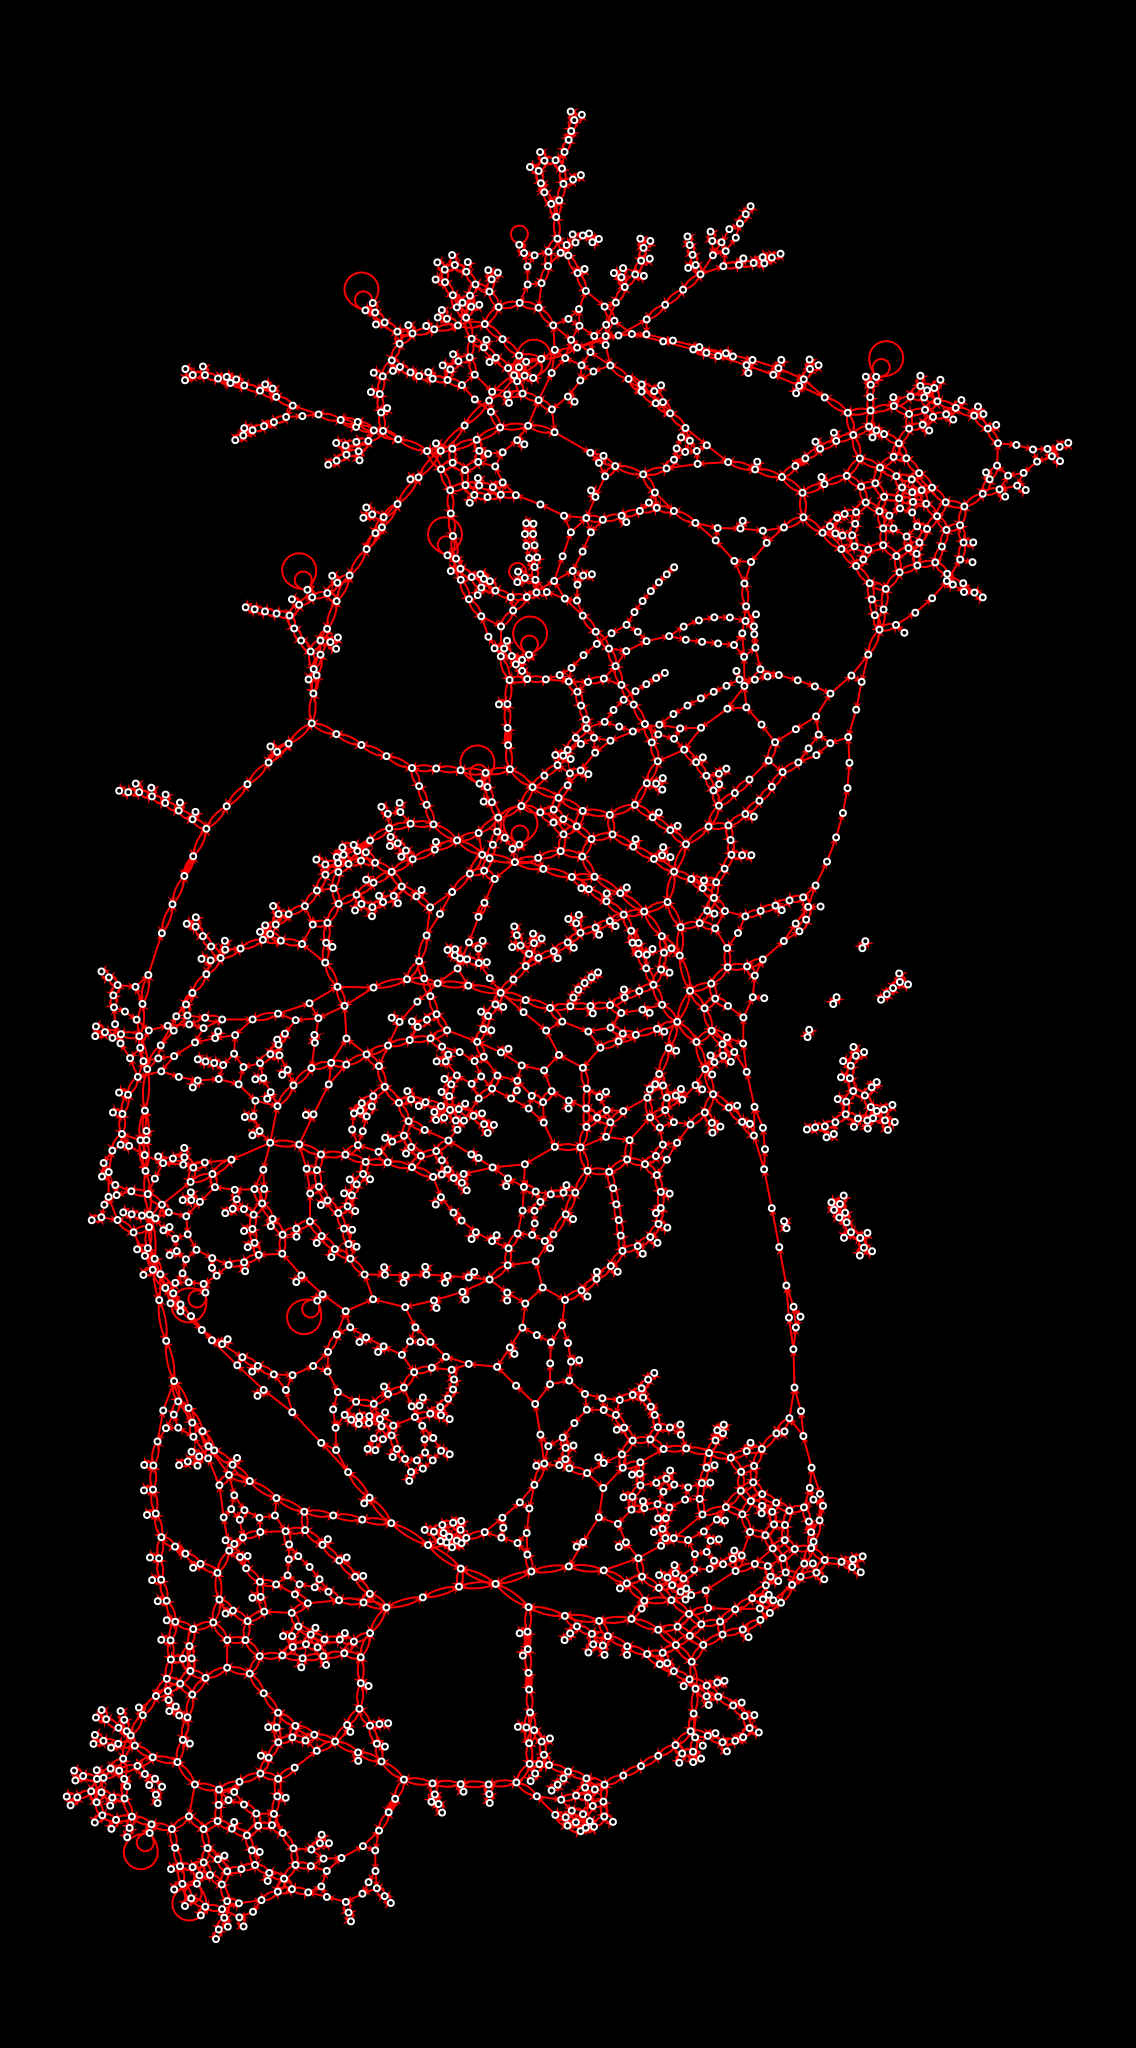

CPU times: user 13.7 s, sys: 111 ms, total: 13.8 s
Wall time: 9.07 s


In [6]:
%%time
graph = roads_initialized.get_graph()

# a plot method has been added on OsmGT.
graph.plot()


## Compute a shortest path 

### With graph-tools function

In [7]:
%%time
# now, we have to define a start point and a end point and get their wkt
start_node_topo_uuid = 47
end_node_topo_uuid = 63

# 'topo_uuid' is generated by osmgt (during the topology processing).
# Some roads has been split that's whyso this id has been created.
start_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == start_node_topo_uuid]
end_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == end_node_topo_uuid]

start_node_wkt = start_node_gdf.iloc[0]["geometry"].wkt
end_node_wkt = end_node_gdf.iloc[0]["geometry"].wkt

# the graph have some methods (graph-tools method always exists!) to find egdes, vertices... Let's use the .find_vertex_from_name(). the wkt is the vertex name...
source_vertex = graph.find_vertex_from_name(start_node_wkt)
target_vertex = graph.find_vertex_from_name(end_node_wkt)

# shortest path computing...
path_vertices, path_edges = shortest_path(
    graph,
    source=source_vertex,
    target=target_vertex,
    weights=graph.edge_weights  # weigth is based on line length
)

# get path by using edge names
roads_ids = [
    graph.edge_names[edge]
    for edge in path_edges
]

roads_gdf_copy = roads_gdf.copy(deep=True)
shortest_path_found = roads_gdf_copy[roads_gdf['topo_uuid'].isin(roads_ids)].to_crs(3857)['geometry'].to_list()
shortest_path_found_gdf = gpd.GeoDataFrame(index=[0], crs="EPSG:3857", geometry=[linemerge(shortest_path_found)])

layers_to_add = [
    {
        "input_gdf": shortest_path_found_gdf,
        "legend": "shortest_path",
        "color": "red",
        "line_width": 5
    },
    {
        "input_gdf": start_node_gdf,
        "legend": "source node",
        "color": "blue",
        "style": "circle",
        "size": 9
    },
    {
        "input_gdf": end_node_gdf,
        "legend": "target node",
        "color": "green",
        "style": "circle",
        "size": 9
    },
]

my_shortest_path_map = EasyMapBokeh(
    "My shortest path 1",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

CPU times: user 259 ms, sys: 12.4 ms, total: 272 ms
Wall time: 277 ms


### With OsmGt function

In [8]:
%%time

start_node_topo_uuid = 47
end_node_topo_uuid = 63

start_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == start_node_topo_uuid]
end_node_gdf = pois_gdf[pois_gdf['topo_uuid'] == end_node_topo_uuid]

start_node = start_node_gdf.iloc[0]["geometry"]
end_node = end_node_gdf.iloc[0]["geometry"]

shortest_paths = OsmGt.shortest_path_from_location(
    "Roanne",
    [
        (start_node, end_node),
        (start_node, end_node),  # duplicate pairs are cleaned
    ],
    mode="pedestrian"
)
layers_to_add = [
    {
        "input_gdf": shortest_paths[["geometry"]],
        "legend": "shortest_path",
        "color": "red",
        "line_width": 5
    },
    {
        "input_gdf": start_node_gdf,
        "legend": "source node",
        "color": "blue",
        "style": "circle",
        "size": 9
    },
    {
        "input_gdf": end_node_gdf,
        "legend": "target node",
        "color": "green",
        "style": "circle",
        "size": 9
    },
]

my_shortest_path_map = EasyMapBokeh(
    "My shortest path 2",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

2020-09-05 19:39:24 - OsmGtShortestPath - INFO     : Shortest path processing...
2020-09-05 19:39:24 - OsmGtShortestPath - INFO     : From location: Roanne
2020-09-05 19:39:24 - OsmGtShortestPath - INFO     : Loading data...
2020-09-05 19:39:25 - OsmGtShortestPath - INFO     : NominatimApi: Query 200:OK in 0.13 sec.
2020-09-05 19:39:26 - OsmGtShortestPath - INFO     : OverpassApi: Query 200:OK in 0.79 sec.
2020-09-05 19:39:26 - OsmGtShortestPath - INFO     : Rebuild network data
2020-09-05 19:39:26 - OsmGtShortestPath - INFO     : Network cleaning...
2020-09-05 19:39:26 - OsmGtShortestPath - INFO     : Starting: Adding new nodes on the network
2020-09-05 19:39:26 - OsmGtShortestPath - INFO     : Find nearest line for each node
2020-09-05 19:39:26 - OsmGtShortestPath - INFO     : Split line
2020-09-05 19:39:26 - OsmGtShortestPath - INFO     : Topology lines checker: to add: 2, to split: 2
2020-09-05 19:39:26 - OsmGtShortestPath - INFO     : Starting: Find intersections
2020-09-05 19:39:

CPU times: user 1.88 s, sys: 59.2 ms, total: 1.94 s
Wall time: 2.93 s


## Compute an isochrone

### Isochrone from times

In [9]:
%%time

start_node_topo_uuid = 47
source_node = pois_gdf[pois_gdf['topo_uuid'] == start_node_topo_uuid]

# 2 = 2 min ; 5 = 5 min ; 10 = 10 min
isochrones_polygon_values = {
    2: "#d9ef8b",
    5: "#fee08b",
    10: "#f46d43"
}

isochrones_lines_values = {
    2: "#668100",
    5: "#e2a803",
    10: "#962603"
}

trip_speed = 3  # km/h

location_point = source_node.iloc[0]["geometry"]
isochrones_polygons, isochrones_lines = OsmGt.isochrone_from_source_node(
    location_point,
    list(isochrones_polygon_values.keys()),
    trip_speed,
    mode="pedestrian"
)

isochrones_polygons["color"] = isochrones_polygons["iso_name"].map(lambda x: isochrones_polygon_values[int(x.split(" ")[0])])
isochrones_lines["color"] = isochrones_lines["iso_name"].map(lambda x: isochrones_lines_values[int(x.split(" ")[0])])


layers_to_add = [
    {
        "input_gdf": isochrones_polygons,
        "legend": "iso_name",
        "fill_color": "color",
        "line_color": "color",
        "fill_alpha": 0.5
    },
    {
        "input_gdf": source_node,
        "legend": "Source node",
        "style": "circle",
        "color": "red",
        "size": 5
    },
    {
        "input_gdf": isochrones_lines,
        "legend": "iso_name",
        "color": "color",
        "line_width": 2
    },
]

my_shortest_path_map = EasyMapBokeh(
    "Isochrones from times",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

2020-09-05 19:39:27 - OsmGtIsochrone  - INFO     : Isochrone processing...
2020-09-05 19:39:27 - OsmGtIsochrone  - INFO     : From bbox: (4.0629714353691035, 46.03634090608913, 4.076446164630895, 46.045694298051714)
2020-09-05 19:39:27 - OsmGtIsochrone  - INFO     : Loading data...
2020-09-05 19:39:28 - OsmGtIsochrone  - INFO     : OverpassApi: Query 200:OK in 0.28 sec.
2020-09-05 19:39:28 - OsmGtIsochrone  - INFO     : Rebuild network data
2020-09-05 19:39:28 - OsmGtIsochrone  - INFO     : Network cleaning...
2020-09-05 19:39:28 - OsmGtIsochrone  - INFO     : Starting: Adding new nodes on the network
2020-09-05 19:39:28 - OsmGtIsochrone  - INFO     : Find nearest line for each node
2020-09-05 19:39:28 - OsmGtIsochrone  - INFO     : Split line
2020-09-05 19:39:28 - OsmGtIsochrone  - INFO     : Topology lines checker: to add: 1, to split: 1
2020-09-05 19:39:28 - OsmGtIsochrone  - INFO     : Starting: Find intersections
2020-09-05 19:39:28 - OsmGtIsochrone  - INFO     : Done: Find inters

ERROR:bokeh.core.validation.check:E-1006 (NON_MATCHING_DATA_SOURCES_ON_LEGEND_ITEM_RENDERERS): LegendItem.label is a field, but renderer data sources don't match: LegendItem(id='1874', ...)


CPU times: user 6.19 s, sys: 112 ms, total: 6.31 s
Wall time: 6.59 s


### Isochrone from distances

In [10]:
%%time
start_node_topo_uuid = 47
source_node = pois_gdf[pois_gdf['topo_uuid'] == start_node_topo_uuid]

trip_speed = 3  # km/h

isochrones_polygon_values = {
    500: "#d9ef8b",
    750: "#fee08b",
    1000: "#f46d43"
}
# 2 = 2 min ; 5 = 5 min ; 10 = 10 min


isochrones_lines_values = {
    500: "#668100",
    750: "#e2a803",
    1000: "#962603"
}

location_point = source_node.iloc[0]["geometry"]
isochrones_polygons, isochrones_lines = OsmGt.isochrone_distance_from_source_node(
    location_point,
    list(isochrones_polygon_values.keys()),  # meters
    trip_speed,
    mode="pedestrian"
)

isochrones_polygons["color"] = isochrones_polygons["iso_distance"].map(lambda x: isochrones_polygon_values[x])
isochrones_lines["color"] = isochrones_lines["iso_distance"].map(lambda x: isochrones_lines_values[x])


layers_to_add = [
    {
        "input_gdf": isochrones_polygons,
        "legend": "iso_distance",
        "fill_color": "color",
        "line_color": "color",
        "fill_alpha": 0.5
    },
    {
        "input_gdf": isochrones_lines,
        "legend": "iso_distance",
        "color": "color",
        "line_width": 2
    },
    {
        "input_gdf": source_node,
        "legend": "Source node",
        "style": "circle",
        "color": "orange",
        "size": 15
    },
]

my_shortest_path_map = EasyMapBokeh(
    "Isochrones from distance",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)


2020-09-05 19:39:34 - OsmGtIsochrone  - INFO     : Isochrone processing...
2020-09-05 19:39:34 - OsmGtIsochrone  - INFO     : From bbox: (4.056234070738207, 46.031663616316784, 4.083183529261792, 46.050370400246656)
2020-09-05 19:39:34 - OsmGtIsochrone  - INFO     : Loading data...
2020-09-05 19:39:34 - OsmGtIsochrone  - INFO     : OverpassApi: Query 200:OK in 0.3 sec.
2020-09-05 19:39:35 - OsmGtIsochrone  - INFO     : Rebuild network data
2020-09-05 19:39:35 - OsmGtIsochrone  - INFO     : Network cleaning...
2020-09-05 19:39:35 - OsmGtIsochrone  - INFO     : Starting: Adding new nodes on the network
2020-09-05 19:39:35 - OsmGtIsochrone  - INFO     : Find nearest line for each node
2020-09-05 19:39:35 - OsmGtIsochrone  - INFO     : Split line
2020-09-05 19:39:35 - OsmGtIsochrone  - INFO     : Topology lines checker: to add: 1, to split: 1
2020-09-05 19:39:35 - OsmGtIsochrone  - INFO     : Starting: Find intersections
2020-09-05 19:39:35 - OsmGtIsochrone  - INFO     : Done: Find interse

ERROR:bokeh.core.validation.check:E-1006 (NON_MATCHING_DATA_SOURCES_ON_LEGEND_ITEM_RENDERERS): LegendItem.label is a field, but renderer data sources don't match: LegendItem(id='2098', ...)


CPU times: user 30.5 s, sys: 141 ms, total: 30.6 s
Wall time: 31 s


### Isochrone style

In [11]:
%%time

# we can change the isochrone style

start_node_topo_uuid = 47
source_node = pois_gdf[pois_gdf['topo_uuid'] == start_node_topo_uuid]

# 2 = 2 min ; 5 = 5 min ; 10 = 10 min
isochrones_polygon_values = {
    2: "#d9ef8b",
    5: "#fee08b",
    10: "#f46d43"
}

isochrones_lines_values = {
    2: "#668100",
    5: "#e2a803",
    10: "#962603"
}

trip_speed = 3  # km/h

location_point = source_node.iloc[0]["geometry"]
isochrones_polygons, isochrones_lines = OsmGt.isochrone_from_source_node(
    location_point,
    list(isochrones_polygon_values.keys()),
    trip_speed,
    mode="pedestrian",
    display_mode="web"  # HERE you can change the style (orthogonal by default, or web)
)

isochrones_polygons["color"] = isochrones_polygons["iso_name"].map(lambda x: isochrones_polygon_values[int(x.split(" ")[0])])
isochrones_lines["color"] = isochrones_lines["iso_name"].map(lambda x: isochrones_lines_values[int(x.split(" ")[0])])


layers_to_add = [
    {
        "input_gdf": isochrones_polygons,
        "legend": "iso_name",
        "fill_color": "color",
        "line_color": "color",
        "fill_alpha": 0.5
    },
    {
        "input_gdf": source_node,
        "legend": "Source node",
        "style": "circle",
        "color": "red",
        "size": 5
    },
    {
        "input_gdf": isochrones_lines,
        "legend": "iso_name",
        "color": "color",
        "line_width": 2
    },
]

my_shortest_path_map = EasyMapBokeh(
    "Isochrones from times",
    layers=layers_to_add
)
show(my_shortest_path_map.figure)

2020-09-05 19:40:05 - OsmGtIsochrone  - INFO     : Isochrone processing...
2020-09-05 19:40:05 - OsmGtIsochrone  - INFO     : From bbox: (4.0629714353691035, 46.03634090608913, 4.076446164630895, 46.045694298051714)
2020-09-05 19:40:05 - OsmGtIsochrone  - INFO     : Loading data...
2020-09-05 19:40:05 - OsmGtIsochrone  - INFO     : OverpassApi: Query 200:OK in 0.31 sec.
2020-09-05 19:40:05 - OsmGtIsochrone  - INFO     : Rebuild network data
2020-09-05 19:40:05 - OsmGtIsochrone  - INFO     : Network cleaning...
2020-09-05 19:40:05 - OsmGtIsochrone  - INFO     : Starting: Adding new nodes on the network
2020-09-05 19:40:05 - OsmGtIsochrone  - INFO     : Find nearest line for each node
2020-09-05 19:40:06 - OsmGtIsochrone  - INFO     : Split line
2020-09-05 19:40:06 - OsmGtIsochrone  - INFO     : Topology lines checker: to add: 1, to split: 1
2020-09-05 19:40:06 - OsmGtIsochrone  - INFO     : Starting: Find intersections
2020-09-05 19:40:06 - OsmGtIsochrone  - INFO     : Done: Find inters

ERROR:bokeh.core.validation.check:E-1006 (NON_MATCHING_DATA_SOURCES_ON_LEGEND_ITEM_RENDERERS): LegendItem.label is a field, but renderer data sources don't match: LegendItem(id='2334', ...)


CPU times: user 6.11 s, sys: 33.8 ms, total: 6.14 s
Wall time: 6.47 s
